In [1]:
from pathlib import Path
import os
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import torch
from gaussian_renderer import GaussianModel, splinerender, render, camera2rays, camera2rays_full
from scene.cameras import Camera
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import imageio
from pyquaternion import Quaternion

class PipelineParams:
    def __init__(self):
        self.convert_SHs_python = True
        self.compute_cov3D_python = False
        self.enable_GLO = False
        self.debug = False

pipeline = PipelineParams()
gaussians = GaussianModel(0, False)

s = 0.25
z = 3
xyz = [
    [0, 0, z+s],
    [0, s, z],
    [-0.86602540378*s, -0.5*s, z],
    [ 0.86602540378*s, -0.5*s, z],
]

features_dc = [
    [[0.1, 0.1, 0.1]],
    [[0.9, 0.1, 0.1]],
    [[0.1, 0.9, 0.1]],
    [[0.1, 0.1, 0.9]],
]
features_extra = np.empty((4, 0, 3))
opacities = [
    0.5, 0.25, 0.5, 1.0,
]
scales = 1.8*np.array([
    [s/2, s/2, 3*s],
    [s, s, s],
    [s, s, s],
    [s, s, s],
])
rots = [
    [0.1, 0.32, 0, 1],
    [0, 0, 0, 1],
    [0, -0.1, 0.5, 1],
    [0.5, 0, -0.1, 1],
]


gaussians._xyz = nn.Parameter(torch.tensor(xyz, dtype=torch.float, device="cuda").requires_grad_(True))
gaussians._features_dc = nn.Parameter(torch.tensor(features_dc, dtype=torch.float, device="cuda").contiguous().requires_grad_(True))
gaussians._features_rest = nn.Parameter(torch.tensor(features_extra, dtype=torch.float, device="cuda").contiguous().requires_grad_(True))
gaussians._opacity = gaussians.inverse_opacity_activation(nn.Parameter(torch.tensor(opacities, dtype=torch.float, device="cuda").requires_grad_(True)))
gaussians._scaling = gaussians.scaling_inverse_activation(nn.Parameter(torch.tensor(scales, dtype=torch.float, device="cuda").requires_grad_(True)))
gaussians._rotation = nn.Parameter(torch.tensor(rots, dtype=torch.float, device="cuda").requires_grad_(True))

background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
image = torch.ones((3, 800, 800), dtype=float)
R = np.eye(3)
T = np.zeros((3))
view = Camera(0, R, T, 30/180*np.pi, 30/180*np.pi, image, image, "fake", 0)
print(view.image_height, view.image_width)
print(gaussians.get_density(), gaussians.get_opacity)

/home/amai/yindaz/gaussian-splatting
['-std=c++17']
['-std=c++17']
800 800
tensor([1.5403, 0.3196, 0.7702, 5.0120], device='cuda:0',
       grad_fn=<ViewBackward0>) tensor([0.5000, 0.2500, 0.5000, 0.9890], device='cuda:0',
       grad_fn=<MulBackward0>)


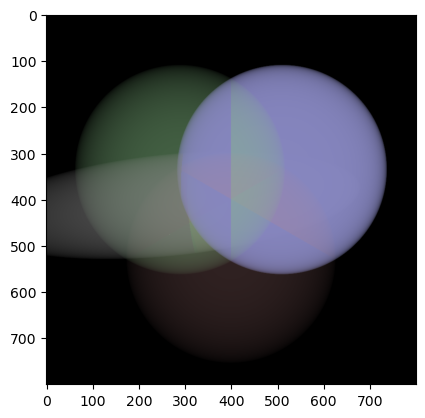

In [2]:
rendering = splinerender(view, gaussians, pipeline, background, random=False, tmin=1.0)["render"]
plt.imshow(rendering.permute(1, 2, 0).detach().cpu())
imageio.imwrite("demo_images/gs.png", (255*rendering.permute(1, 2, 0).detach().cpu()).clip(min=0, max=255).byte())

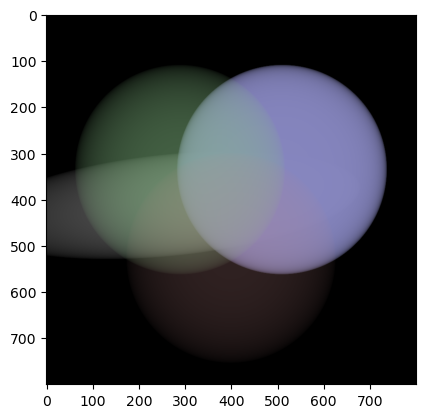

In [3]:
rendering = render(view, gaussians, pipeline, background, random=False, tmin=1.0)["render"]
plt.imshow(rendering.permute(1, 2, 0).detach().cpu())
imageio.imwrite("demo_images/3dgs.png", (255*rendering.permute(1, 2, 0).detach().cpu()).clip(min=0, max=255).byte())

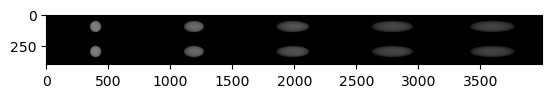

In [4]:


s = 0.25
z = 3
xyz = [
    [0, 0, z+s],
]

features_dc = [
    [[0.1, 0.1, 0.1]],
]
features_extra = np.empty((1, 0, 3))
opacities = [
    0.5,
]
scales = 0.8*np.array([
    [s/2, s/2, 2*s],
])

gaussians._xyz = nn.Parameter(torch.tensor(xyz, dtype=torch.float, device="cuda").requires_grad_(True))
gaussians._features_dc = nn.Parameter(torch.tensor(features_dc, dtype=torch.float, device="cuda").contiguous().requires_grad_(True))
gaussians._features_rest = nn.Parameter(torch.tensor(features_extra, dtype=torch.float, device="cuda").contiguous().requires_grad_(True))
gaussians._opacity = gaussians.inverse_opacity_activation(nn.Parameter(torch.tensor(opacities, dtype=torch.float, device="cuda").requires_grad_(True)))
gaussians._scaling = gaussians.scaling_inverse_activation(nn.Parameter(torch.tensor(scales, dtype=torch.float, device="cuda").requires_grad_(True)))

views = []
for angle in torch.linspace(0, np.pi/2, 5):
    q = Quaternion(axis=[0, 1, 0], angle=angle).elements
    rots = [[q[0], q[1], q[2], q[3]]]
    gaussians._rotation = nn.Parameter(torch.tensor(rots, dtype=torch.float, device="cuda").requires_grad_(True))

    i = 300
    rendering = render(view, gaussians, pipeline, background, random=False, tmin=1.0)["render"]
    rendering = rendering.permute(1, 2, 0).detach().cpu()
    gview = rendering[i:-i]
    rendering = splinerender(view, gaussians, pipeline, background, random=False, tmin=1.0)["render"]
    rendering = rendering.permute(1, 2, 0).detach().cpu()
    sview = rendering[i:-i]
    stacked = torch.cat([gview, sview], dim=0)
    views.append(stacked)
views = torch.cat(views, dim=1)
plt.imshow(views)

In [5]:

plt.imshow(torch.cat([view1, view2], dim=1))

NameError: name 'view1' is not defined